In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [4]:
def get_cluster(workers=30,project = 'P93300641'):

    cluster = PBSCluster(
        cores=1, # The number of cores you want
        memory='10GB', # Amount of memory
        processes=1, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        local_directory='$TMPDIR', # Use your local directory
        resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
        account=project, # Input your project ID here
        walltime='01:30:00', # Amount of wall time
    )
    
    # Scale up
    cluster.scale(workers)
    
    # Setup your client
    client = Client(cluster)
    return client

In [23]:
def pftgrid(ds,v,pft):
    nlon=len(ds.lon)
    nlat=len(ds.lat)
    nt=len(ds.time)

    out=xr.DataArray(np.zeros([nlat,nlon,1,nt])+np.nan,
                     coords={'lat':ds.lat,'lon':ds.lon,'PFT':[pft],'time':ds.time}
                    ).stack({'gridcell':['lat','lon']})

    ixpft=(ds.pfts1d_itype_veg==pft).compute()
    ixy=ds.pfts1d_ixy.isel(pft=ixpft)
    jxy=ds.pfts1d_jxy.isel(pft=ixpft)
    regridder=(jxy*nlon+ixy).astype(int).compute() #this could be reused if you regrid multiple variables

    out[0,:,regridder]=ds[v].isel(pft=ixpft)
    return out.unstack()

In [5]:
client=get_cluster()

In [8]:
d='/glade/campaign/cgd/tss/projects/TRENDY/v12/S3/lnd/proc/tseries/month_1/'
f='TRENDY2023_f09_S3.clm2.h1.TLAI.170101-202212.nc'
ds=xr.open_dataset(d+f,chunks={'time':12})

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.11/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 12. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [24]:
%%time
lai_14=pftgrid(ds,'TLAI',14)

CPU times: user 6.86 s, sys: 1.8 s, total: 8.66 s
Wall time: 20.2 s


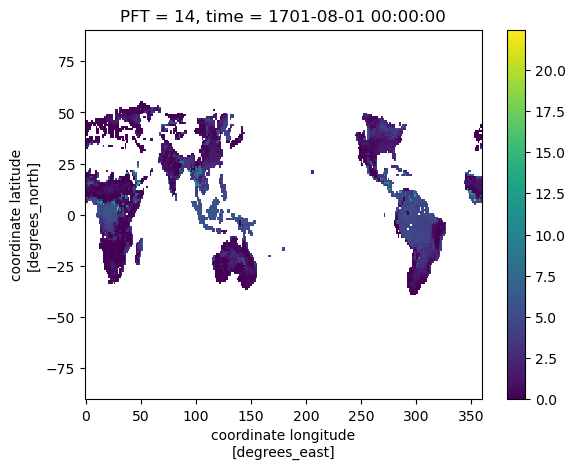

In [27]:
lai_14.isel(time=6,PFT=0).plot();